1) 고객들을 분류하고
각 그룹별 페르소나 정의
그리고 분석을 통한 그룹별 전략 제시
이것까지 한판 정리로 끝내고

2) 개개인의 초맞춤형 전략을 위한
고객들의 장바구니 분석으로 연관 상품 추천
그리고 평균 구매 주기를 예측해 언제 추천해줄지
what? when을 해결하는 방식으로

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# 폰트 = applegothic
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

# 숫자 정수로 표현
pd.options.display.float_format = '{:.2f}'.format

# 1. 데이터 불러오기 및 테이블 정리

In [123]:
df_on = pd.read_csv('data/Onlinesales_info.csv')
df_cus = pd.read_csv('data/Customer_info.csv')
df_dis = pd.read_csv('data/Discount_info.csv')
df_mar = pd.read_csv('data/Marketing_info.csv')
df_tax = pd.read_csv('data/Tax_info.csv')

테이블 ERD 생성
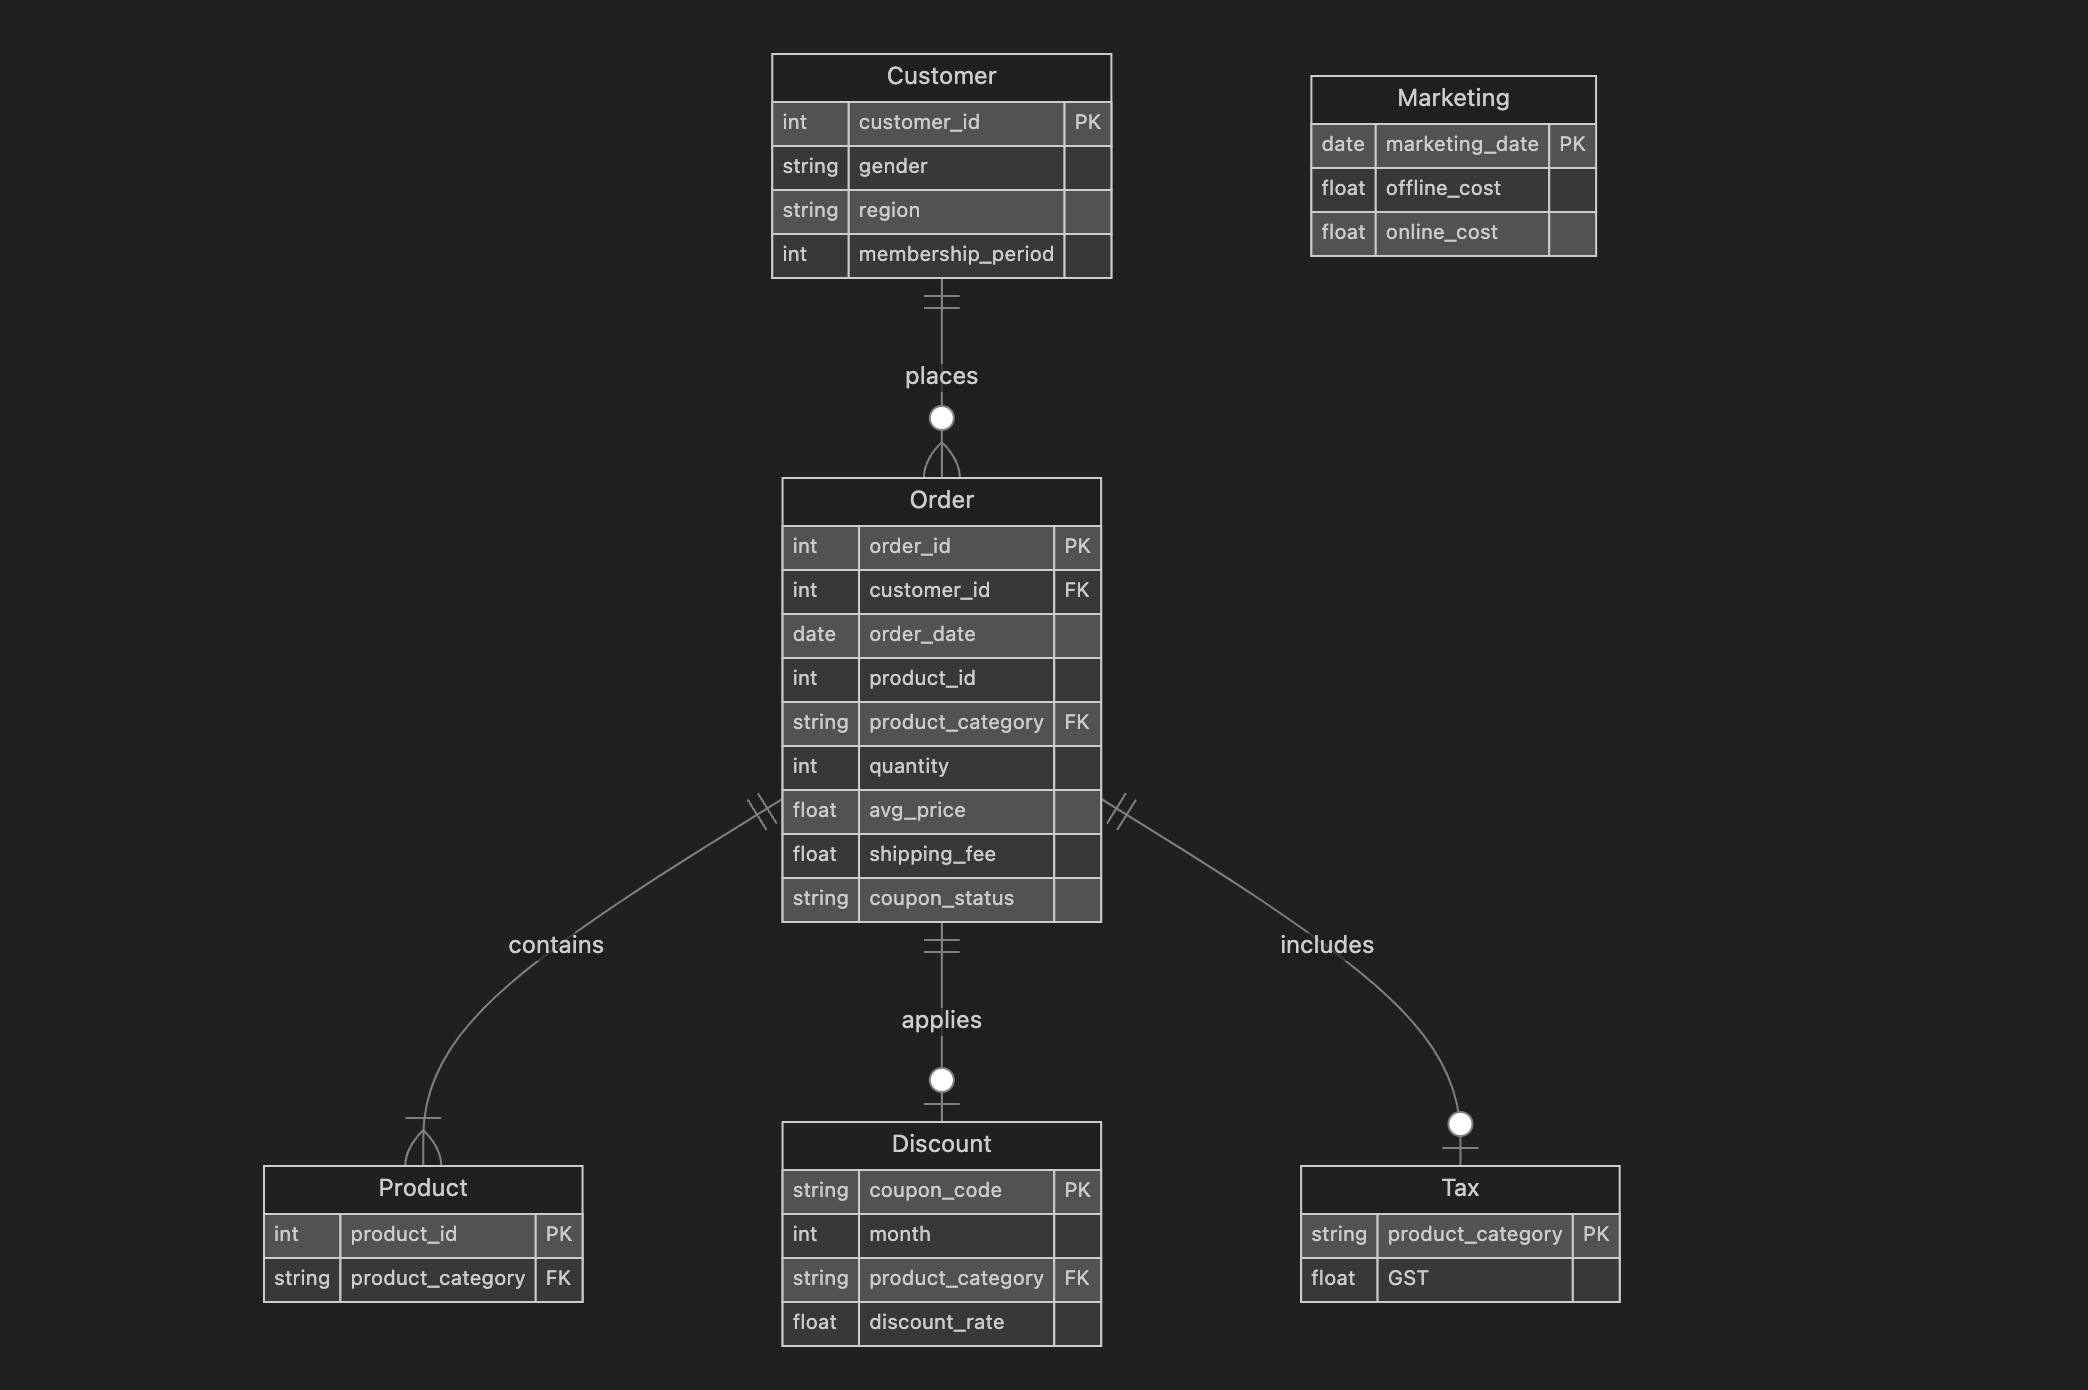

- 현재 진행하고자 하는 분석은 df_on에서 대부분 계산 후 사용 가능하다
- 좀 더 딥다이브한 분석이 필요한 경우만 join해서 사용하는 형태로 진행하자

# 2. 고객 분류

## 2.1 lifetimes 라이브러리를 사용한 RTFM 변수 및 CLV 변수 생성
- clv를 계산하는 방법도 있으나 예측하는 방식을 택함.
- 단순 계산 방식보다 예측 방식이 미래 구매 패턴을 반영할 수 있음

1) BG/NBD 모델을 사용하여 고객별 미래 구매 횟수를 예측

2) Gamma-Gamma 모델을 사용하여 고객별 평균 구매 금액을 예측

In [124]:
# 총금액이 들어있는 것이 아닌 평균 금액이 들어있으므로 거래마다의 총 구매금액 컬럼을 새롭게 생성한다.
df_on['총구매금액'] = df_on['평균금액'] * df_on['수량']

In [177]:
import pandas as pd

# 거래 날짜를 datetime 형식으로 변환
df_on['거래날짜'] = pd.to_datetime(df_on['거래날짜'])

# 현재 기준 날짜 (가장 최신 거래 날짜) - 2019년 1년간의 데이터임.
latest_date = df_on['거래날짜'].max()

# 고객별 첫 구매 일자 (Tenure 계산을 위해 필요)
first_purchase = df_on.groupby('고객ID')['거래날짜'].min()

# 고객별 마지막 거래 일자
latest_purchase = df_on.groupby('고객ID')['거래날짜'].max()

# Recency 계산 (마지막 구매일 이후 경과 일수)
recency = (latest_date - latest_purchase).dt.days

# Frequency 계산 (총 거래 횟수 - 첫 구매 1회 제외)
frequency = df_on.groupby('고객ID')['거래ID'].count() - 1  # lifetimes에서는 첫 구매 제외

# Monetary 계산 (개별 거래당 평균 금액으로 변환)
monetary = df_on.groupby('고객ID')['총구매금액'].mean() # lifetimes에서는 평균 구매 금액 사용

# Tenure (최초 구매 이후 현재까지 경과 일수)
T = (latest_date - first_purchase).dt.days

# lifetimes을 위한 데이터프레임 생성
clv_df = pd.DataFrame({
    '고객ID': recency.index,
    'recency': recency.values,
    'frequency': frequency.values,
    'monetary': monetary.values,
    'T': T.values
})

clv_df

,고객ID,recency,frequency,monetary,T
0,USER_0000,107,1,15.49,107
1,USER_0001,59,59,230.58,282
2,USER_0002,73,22,62.70,192
3,USER_0003,17,16,80.00,17
4,USER_0004,107,35,40.07,107
...,...,...,...,...,...
1463,USER_1463,270,6,77.76,270
1464,USER_1464,87,39,59.08,192
1465,USER_1465,194,7,12.70,270
1466,USER_1466,69,0,298.00,69


In [178]:
# recency와 T 변수는 주단위로 계산할 것을 권장하고 있으므로 변환해줌.
clv_df["recency"] = clv_df["recency"] / 7
clv_df["T"] = clv_df["T"] / 7

# frequency = 0인 고객의 recency를 0으로 설정 (lifetimes 규칙) - 첫구매 이후 행동을 예측하는 거라 첫구매만 한 경우는 모두 제외가 되어야 함.
clv_df.loc[clv_df['frequency'] == 0, 'recency'] = 0

clv_df

,고객ID,recency,frequency,monetary,T
0,USER_0000,15.29,1,15.49,15.29
1,USER_0001,8.43,59,230.58,40.29
2,USER_0002,10.43,22,62.70,27.43
3,USER_0003,2.43,16,80.00,2.43
4,USER_0004,15.29,35,40.07,15.29
...,...,...,...,...,...
1463,USER_1463,38.57,6,77.76,38.57
1464,USER_1464,12.43,39,59.08,27.43
1465,USER_1465,27.71,7,12.70,38.57
1466,USER_1466,0.00,0,298.00,9.86


In [179]:
# 구매 빈도와 구매 금액이 너무 높은 고객을 이상치로 판단하여 제거
# 하지만 상위 유저가 중요하다는 점을 고려하여 최소한의 고객들만 제거하기 위해 상위 99.5% 위로만 제거 진행함.

# Frequency가 상위 99.5% 이상인 고객 제거
upper_limit = clv_df['frequency'].quantile(0.995)
clv_df = clv_df[clv_df['frequency'] < upper_limit]

# Monetary가 상위 99.5% 이상인 고객 제거
upper_limit_monetary = clv_df['monetary'].quantile(0.995)
clv_df = clv_df[clv_df['monetary'] < upper_limit_monetary]

print(clv_df.describe())  # 데이터 정리 후 확인

# 1468명에서 1452명으로 데이터 정리 완료

       recency  frequency  monetary       T
count  1452.00    1452.00   1452.00 1452.00
mean     19.41      32.60     85.16   29.71
std      14.76      36.92     48.65   14.91
min       0.00       0.00      1.00    0.00
25%       5.86       9.00     53.00   18.29
50%      17.36      20.00     79.23   31.64
75%      29.86      44.00    108.44   41.86
max      51.86     289.00    313.53   52.00


BG/NBD 모델은 BTYD (Buy Till You Die) 모형이라고도 불린다.

- 구매 횟수에 대한 "Buy"에 대한 모형과 (“미래에 유저가 몇 번 구매할까?”에 대한 모델)
    - 포아송 분포 (단위 시간 동안의 성공 횟수에 대한 분포) + 감마 분포 (사건을 n번 시행할 때까지의 총 시간에 대한 분포)
- 어느 시점 이후 구매를 하지 않을 확률 "Till You Die"에 대한 모형(“미래에 유저가 언제 구매를 중단할까?”에 대한 모델)으로 나뉨.
    - 베타 분포 (확률에 대한 분포)+ 기하 분포 (사건이 1번 발생할 때까지의 시행 횟수에 대한 분포)

> 각 분포가 이해가 안간다면 쉽게 예를 통해 살펴보자!

실제 나의 최근 약 3개월 간의 지그재그 주문 내역을 가져왔다.

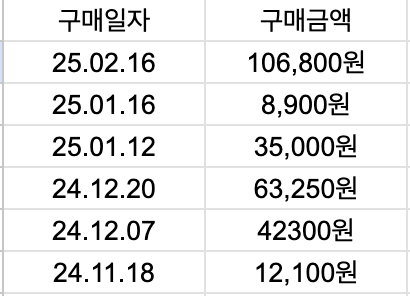

1. 포아송 분포: 3개월에 거쳐 6번 구매했으니 한 달에 2번 구매한 꼴. 이처럼 한 달의 평균 구매 횟수가 포아송 분포를 따른다 가정한다.
2. 기하 분포: 여기서의 사건은 “더 이상 구매하지 않는다”라는 것입니다. 더 이상 구매하지 않을 때까지의 총 구매 횟수는 기하 분포를 따른다 가정한다.
3. 베타 분포: 마지막으로 이 이탈률 p는 베타 분포를 따른다 가정한다.

유저마다 별개의 과거의 구매 정보 RFMT 정보를 가지고 위 분포를 따른다 가정하여 가능도 함수를 구해 기댓값을 구하면 유저마다 다른 기대 구매 횟수를 모델링 할 수 있는 것임!!

In [180]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# 모델 선언
bgf = BetaGeoFitter(penalizer_coef=0.01)  # BG/NBD 모델
ggf = GammaGammaFitter(penalizer_coef=0.01)  # 감마-감마 모델

# 모델 학습
bgf.fit(clv_df['frequency'], clv_df['recency'], clv_df['T'])

# 감마-감마 모델 학습 (frequency > 0 인 고객들만 사용)
clv_df_filtered = clv_df[clv_df['frequency'] > 0]
ggf.fit(clv_df_filtered['frequency'], clv_df_filtered['monetary'])

# 3개월(12주) 내 예상 구매 횟수 예측 (모든 고객)
clv_df['predicted_purchases_3_months'] = bgf.predict(12, clv_df['frequency'], clv_df['recency'], clv_df['T'])

# 3개월 CLV 예측 (frequency > 0 인 고객만 감마-감마 모델 사용)
clv_df.loc[clv_df['frequency'] > 0, 'CLV_3_months'] = ggf.customer_lifetime_value(
    bgf,
    clv_df.loc[clv_df['frequency'] > 0, 'frequency'],
    clv_df.loc[clv_df['frequency'] > 0, 'recency'],
    clv_df.loc[clv_df['frequency'] > 0, 'T'],
    clv_df.loc[clv_df['frequency'] > 0, 'monetary'],
    time=3,  # 3개월 예측
    freq='W',  # 주 단위
    discount_rate=0.01
)

# frequency = 0인 고객들의 CLV 추정 (자신의 monetary 값 사용)
clv_df.loc[clv_df['frequency'] == 0, 'CLV_3_months'] = (
    clv_df.loc[clv_df['frequency'] == 0, 'predicted_purchases_3_months'] * 
    clv_df.loc[clv_df['frequency'] == 0, 'monetary']
)

clv_df

,고객ID,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months
0,USER_0000,15.29,1,15.49,15.29,0.96,22.04
1,USER_0001,8.43,59,230.58,40.29,0.00,0.00
2,USER_0002,10.43,22,62.70,27.43,0.00,0.00
3,USER_0003,2.43,16,80.00,2.43,66.24,5653.38
4,USER_0004,15.29,35,40.07,15.29,26.24,1122.34
...,...,...,...,...,...,...,...
1463,USER_1463,38.57,6,77.76,38.57,1.90,160.70
1464,USER_1464,12.43,39,59.08,27.43,0.00,0.00
1465,USER_1465,27.71,7,12.70,38.57,1.85,26.44
1466,USER_1466,0.00,0,298.00,9.86,0.41,121.60


In [181]:
print(f"Gamma-Gamma 모델 학습된 파라미터: {ggf.params_}")

Gamma-Gamma 모델 학습된 파라미터: p   4.02
q   0.60
v   3.99
dtype: float64


In [182]:
clv_df.describe()

,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months
count,1452.00,1452.00,1452.00,1452.00,1452.00,1452.00
mean,19.41,32.60,85.16,29.71,15.62,1846.24
std,14.76,36.92,48.65,14.91,78.85,12222.64
min,0.00,0.00,1.00,0.00,0.00,0.00
25%,5.86,9.00,53.00,18.29,0.00,0.00
50%,17.36,20.00,79.23,31.64,2.39,151.10
75%,29.86,44.00,108.44,41.86,10.49,889.93
max,51.86,289.00,313.53,52.00,2184.39,365778.89


In [183]:
# 왜 rfm 지표들이 모두 좋은데 clv가 낮을까?
clv_df[clv_df['CLV_3_months'] > 1].describe()

,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months
count,1012.00,1012.00,1012.00,1012.00,1012.00,1012.00
mean,23.27,20.88,84.95,26.31,22.41,2648.93
std,15.26,23.37,52.93,15.17,93.65,14569.91
min,0.00,0.00,3.67,0.00,0.01,1.12
25%,10.29,6.00,47.03,13.43,1.92,121.80
50%,22.57,14.00,76.77,26.93,6.23,468.87
75%,36.43,27.00,112.20,38.61,16.87,1483.03
max,51.86,259.00,313.53,52.00,2184.39,365778.89


In [184]:
# 가설! 구매 패턴이 불규칙한 고객인거 아닐까?

# 고객별 구매 간격 계산
df_on['구매간격'] = df_on.groupby('고객ID')['거래날짜'].diff().dt.days  # 거래 간격(일 단위)
interval_analysis = df_on.groupby('고객ID')['구매간격'].std().reset_index()  # 고객별 구매 간격 표준편차 계산

# CLV가 1 미만인 고객들의 구매 간격 불규칙성 확인
clv_low_customers = clv_df[clv_df['CLV_3_months'] < 1][['고객ID']]
clv_low_customers = clv_low_customers.merge(interval_analysis, on='고객ID', how='left')

print(clv_low_customers['구매간격'].describe())

# 1️) CLV가 낮은 고객들은 최근에도 구매를 했기 때문에, 단순히 이탈 고객이라고 볼 수는 없음.
# 2️) 하지만 구매 간격이 불규칙적이며, 특히 일부 고객들은 90일~100일 이상 구매 간격이 있음.
# 3️) BG/NBD 모델은 구매 간격이 일정한 고객을 더 긍정적으로 평가하는 경향이 있음.
# 4️) 즉, 구매 간격이 불규칙한 고객일수록, 모델이 "미래 구매 가능성이 낮다"라고 판단했을 가능성이 크다고 확인됨.
# 모델 결과를 신뢰하는 것으로 결정하고 모든 변수들을 고려해서 클러스터링 해보자!

count   430.00
mean     23.29
std      15.27
min       3.18
25%      12.68
50%      19.84
75%      29.96
max     114.88
Name: 구매간격, dtype: float64


In [185]:
clv_df

,고객ID,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months
0,USER_0000,15.29,1,15.49,15.29,0.96,22.04
1,USER_0001,8.43,59,230.58,40.29,0.00,0.00
2,USER_0002,10.43,22,62.70,27.43,0.00,0.00
3,USER_0003,2.43,16,80.00,2.43,66.24,5653.38
4,USER_0004,15.29,35,40.07,15.29,26.24,1122.34
...,...,...,...,...,...,...,...
1463,USER_1463,38.57,6,77.76,38.57,1.90,160.70
1464,USER_1464,12.43,39,59.08,27.43,0.00,0.00
1465,USER_1465,27.71,7,12.70,38.57,1.85,26.44
1466,USER_1466,0.00,0,298.00,9.86,0.41,121.60


## 2.2 RFMT + CLV 변수를 활용한 클러스터링 작업

In [186]:
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

cluster = clv_df.drop(['predicted_purchases_3_months'], axis = 1)
cluster.set_index("고객ID", inplace=True)
cluster

,recency,frequency,monetary,T,CLV_3_months
고객ID,,,,,
USER_0000,15.29,1,15.49,15.29,22.04
USER_0001,8.43,59,230.58,40.29,0.00
USER_0002,10.43,22,62.70,27.43,0.00
USER_0003,2.43,16,80.00,2.43,5653.38
USER_0004,15.29,35,40.07,15.29,1122.34
...,...,...,...,...,...
USER_1463,38.57,6,77.76,38.57,160.70
USER_1464,12.43,39,59.08,27.43,0.00
USER_1465,27.71,7,12.70,38.57,26.44


In [187]:
X= MinMaxScaler().fit_transform(cluster)

sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

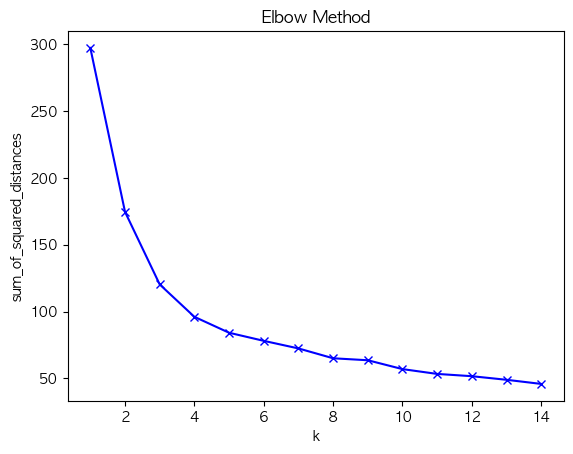

In [188]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method')
plt.show()

# 클러스터 개수는 4개로 결정.

In [190]:
k_means = KMeans(n_clusters=4)
model = k_means.fit(X)
y_hat = k_means.predict(X)
labels = k_means.labels_
metrics.silhouette_score(X, labels, metric = 'euclidean')

0.3356866169061944

In [192]:
cluster['Cluster'] = labels

In [195]:
cluster

,recency,frequency,monetary,T,CLV_3_months,Cluster
고객ID,,,,,,
USER_0000,15.29,1,15.49,15.29,22.04,3
USER_0001,8.43,59,230.58,40.29,0.00,2
USER_0002,10.43,22,62.70,27.43,0.00,3
USER_0003,2.43,16,80.00,2.43,5653.38,1
USER_0004,15.29,35,40.07,15.29,1122.34,3
...,...,...,...,...,...,...
USER_1463,38.57,6,77.76,38.57,160.70,0
USER_1464,12.43,39,59.08,27.43,0.00,3
USER_1465,27.71,7,12.70,38.57,26.44,3


In [196]:
table = cluster.groupby('Cluster').agg({'recency': 'mean', 'frequency':'mean', 'monetary': 'mean','CLV_3_months':'mean'})
table['cluster 분류'] = cluster['Cluster'].value_counts()
table

,recency,frequency,monetary,CLV_3_months,cluster 분류
Cluster,,,,,
0,40.36,25.67,85.89,491.74,350
1,6.34,23.68,106.96,6260.65,365
2,8.80,57.69,86.53,1.21,357
3,22.63,23.99,62.25,586.98,380


In [197]:
cluster

,recency,frequency,monetary,T,CLV_3_months,Cluster
고객ID,,,,,,
USER_0000,15.29,1,15.49,15.29,22.04,3
USER_0001,8.43,59,230.58,40.29,0.00,2
USER_0002,10.43,22,62.70,27.43,0.00,3
USER_0003,2.43,16,80.00,2.43,5653.38,1
USER_0004,15.29,35,40.07,15.29,1122.34,3
...,...,...,...,...,...,...
USER_1463,38.57,6,77.76,38.57,160.70,0
USER_1464,12.43,39,59.08,27.43,0.00,3
USER_1465,27.71,7,12.70,38.57,26.44,3


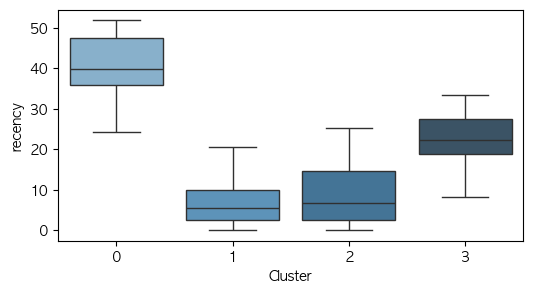

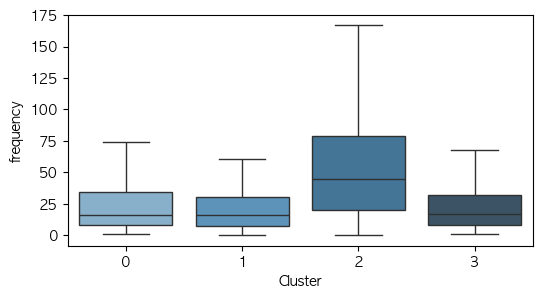

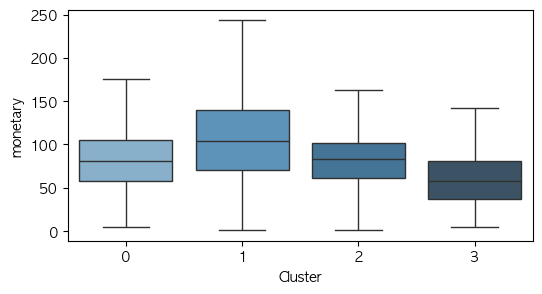

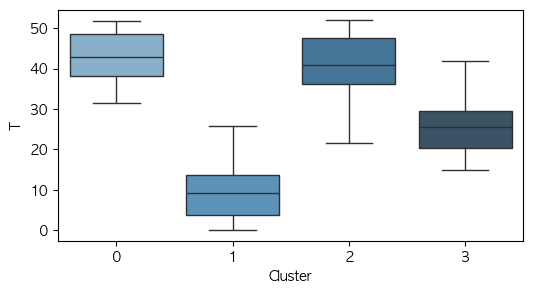

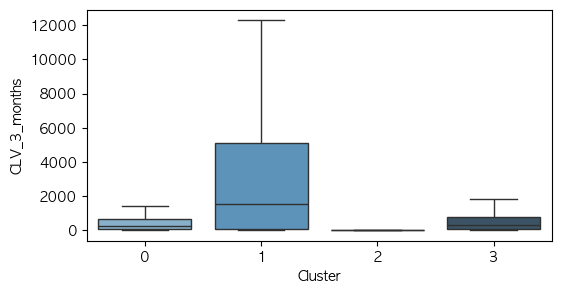

In [215]:
# 이상치 제외하고 시각화한 결과
for i,c in enumerate(list(cluster.columns[:5])):
    plt.figure(figsize = (6,3))
    sns.boxplot(y = cluster[c], x = cluster['Cluster'], order = [0,1,2,3], palette='Blues_d', showfliers=False)
    plt.show()

## 2.3 클러스터링에 큰 영향을 미치는 변수 분석을 위한 LGBM 적용 및 중요도 확인

In [211]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

# 필요 컬럼만 선택
TARGET = 'Cluster'

# Train/Test 분할
X = cluster.drop(columns=[TARGET])
y = cluster[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# StandardScaler 적용
scaler = StandardScaler()
scale_columns = X.columns  # 모든 컬럼에 적용
X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

lgbm = LGBMClassifier(random_state=42, verbose=-1)
lgbm.fit(X_train, y_train)

# 최적 모델 평가
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"LightGBM 테스트 정확도: {accuracy:.4f}")
print(f"LightGBM F1-score: {f1:.4f}")

LightGBM 테스트 정확도: 0.9863
LightGBM F1-score: 0.9862


가중치 계산


🔍 Feature Importance 가중치 변환 결과:
recency: 0.2782
frequency: 0.1076
monetary: 0.1868
T: 0.2858
CLV_3_months: 0.1417


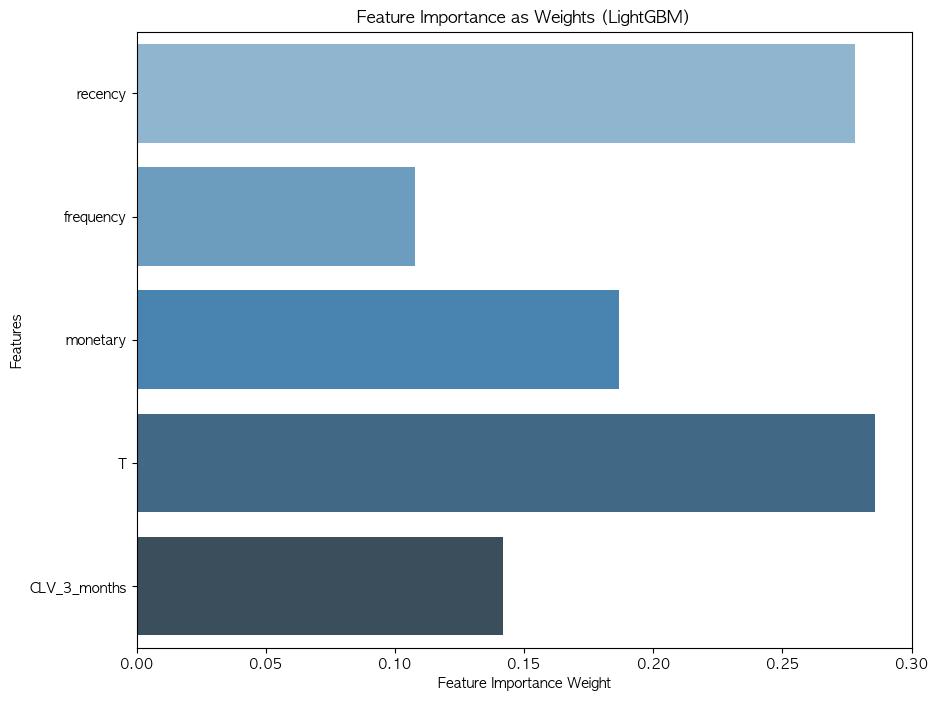

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LightGBM 최적 모델의 Feature Importance 가져오기
feature_importances = lgbm.feature_importances_
feature_names = X.columns

# Feature Importance를 가중치로 변환
feature_weights = feature_importances / feature_importances.sum()  # 전체 합으로 나눠 정규화

# 가중치 출력 (변수별 중요도 비율)
print("\n🔍 Feature Importance 가중치 변환 결과:")
for feature, weight in zip(feature_names, feature_weights):
    print(f"{feature}: {round(weight, 4)}")

# Feature Importance 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_weights, y=feature_names, palette='Blues_d')
plt.xlabel("Feature Importance Weight")
plt.ylabel("Features")
plt.title("Feature Importance as Weights (LightGBM)")
plt.show()


가중치 적용한 최종 점수 만들기

In [218]:
# 각각의 컬럼을 스코어링 한 후에 가중치를 곱해주어 최종 점수를 계산한다.
# 여기서 T값은 일반적으로 길수록 오래전부터 사용한 고객이라고 생각할 수 있으므로 클수록 좋은 스코어를 받을 수 있도록 세팅하였다
# recency만 유일하게 짧을수록 좋은 값이므로 반대로 설정해두었다.

import pandas as pd

# 4분위수 기준으로 스코어링하는 함수
def quartile_scoring(series, reverse=False):
    """
    - series: 점수를 부여할 Series 데이터
    - reverse: True면 점수를 반전 (Recency처럼 낮을수록 좋은 경우)
    - 1~4점 부여 (1: 낮음, 4: 높음)
    """
    qcut_labels = [1, 2, 3, 4]  # 4분위 구간별 점수
    scores = pd.qcut(series, q=4, labels=qcut_labels, duplicates='drop').astype(int)
    
    return 5 - scores if reverse else scores  # Recency는 점수 반전 (1↔4, 2↔3)

# 스코어링 적용
clv_df['R_score'] = quartile_scoring(clv_df['recency'], reverse=True)  # 작을수록 좋음 (반전)
clv_df['F_score'] = quartile_scoring(clv_df['frequency'], reverse=False)  # 클수록 좋음
clv_df['M_score'] = quartile_scoring(clv_df['monetary'], reverse=False)  # 클수록 좋음
clv_df['T_score'] = quartile_scoring(clv_df['T'], reverse=False)  # 클수록 좋음
clv_df['CLV_score'] = quartile_scoring(clv_df['CLV_3_months'], reverse=False)  # 클수록 좋음

# 결과 확인
clv_df

,고객ID,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months,R_score,F_score,M_score,T_score,CLV_score
0,USER_0000,15.29,1,15.49,15.29,0.96,22.04,3,1,1,1,2
1,USER_0001,8.43,59,230.58,40.29,0.00,0.00,3,4,4,3,1
2,USER_0002,10.43,22,62.70,27.43,0.00,0.00,3,3,2,2,1
3,USER_0003,2.43,16,80.00,2.43,66.24,5653.38,4,2,3,1,4
4,USER_0004,15.29,35,40.07,15.29,26.24,1122.34,3,3,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,38.57,6,77.76,38.57,1.90,160.70,1,1,2,3,3
1464,USER_1464,12.43,39,59.08,27.43,0.00,0.00,3,3,2,2,1
1465,USER_1465,27.71,7,12.70,38.57,1.85,26.44,2,1,1,3,2
1466,USER_1466,0.00,0,298.00,9.86,0.41,121.60,4,1,4,1,2


In [219]:
# 스코어링 컬럼명 리스트
score_columns = ['R_score', 'F_score', 'M_score', 'T_score', 'CLV_score']

# 스코어 컬럼과 Feature Importance 가중치를 매핑
score_weights = dict(zip(score_columns, feature_weights))  # 기존 Feature Importance 가중치 사용

# 최종 점수(final_score) 계산 (각 스코어에 가중치 곱하기)
clv_df['final_score'] = sum(clv_df[score] * weight for score, weight in score_weights.items())

# 최종 결과 확인
clv_df

,고객ID,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months,R_score,F_score,M_score,T_score,CLV_score,final_score
0,USER_0000,15.29,1,15.49,15.29,0.96,22.04,3,1,1,1,2,1.70
1,USER_0001,8.43,59,230.58,40.29,0.00,0.00,3,4,4,3,1,3.01
2,USER_0002,10.43,22,62.70,27.43,0.00,0.00,3,3,2,2,1,2.24
3,USER_0003,2.43,16,80.00,2.43,66.24,5653.38,4,2,3,1,4,2.74
4,USER_0004,15.29,35,40.07,15.29,26.24,1122.34,3,3,1,1,4,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,38.57,6,77.76,38.57,1.90,160.70,1,1,2,3,3,2.04
1464,USER_1464,12.43,39,59.08,27.43,0.00,0.00,3,3,2,2,1,2.24
1465,USER_1465,27.71,7,12.70,38.57,1.85,26.44,2,1,1,3,2,1.99
1466,USER_1466,0.00,0,298.00,9.86,0.41,121.60,4,1,4,1,2,2.54


In [220]:
clv_df['final_score'].describe()

count   1452.00
mean       2.50
std        0.42
min        1.42
25%        2.21
50%        2.52
75%        2.79
max        3.57
Name: final_score, dtype: float64

In [224]:
clv_df[clv_df['final_score']>=2.0]

,고객ID,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months,R_score,F_score,M_score,T_score,CLV_score,final_score
1,USER_0001,8.43,59,230.58,40.29,0.00,0.00,3,4,4,3,1,3.01
2,USER_0002,10.43,22,62.70,27.43,0.00,0.00,3,3,2,2,1,2.24
3,USER_0003,2.43,16,80.00,2.43,66.24,5653.38,4,2,3,1,4,2.74
4,USER_0004,15.29,35,40.07,15.29,26.24,1122.34,3,3,1,1,4,2.20
6,USER_0006,27.00,90,75.98,31.29,0.03,2.66,2,4,2,2,2,2.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,USER_1461,2.57,20,114.12,2.57,78.40,9520.92,4,2,4,1,4,2.93
1463,USER_1463,38.57,6,77.76,38.57,1.90,160.70,1,1,2,3,3,2.04
1464,USER_1464,12.43,39,59.08,27.43,0.00,0.00,3,3,2,2,1,2.24
1466,USER_1466,0.00,0,298.00,9.86,0.41,121.60,4,1,4,1,2,2.54


## 2.4 최종 점수를 활용한 고객 segment 생성

In [229]:
# 고객 그룹 설정 함수
def segment_customer(score):
    if score >= 3.2: # 70
        return 'VIP'
    elif score >= 2.8: # 289
        return 'Gold'
    elif score >= 2.4: #500
        return 'Silver'
    elif score >= 2.0: # 383
        return 'Bronze'
    else: # 210
        return 'At Risk'  # 이탈 직전 그룹

# 고객 그룹 분류 적용
clv_df['customer_segment'] = clv_df['final_score'].apply(segment_customer)

# 결과 확인
clv_df


,고객ID,recency,frequency,monetary,T,predicted_purchases_3_months,CLV_3_months,R_score,F_score,M_score,T_score,CLV_score,final_score,customer_segment
0,USER_0000,15.29,1,15.49,15.29,0.96,22.04,3,1,1,1,2,1.70,At Risk
1,USER_0001,8.43,59,230.58,40.29,0.00,0.00,3,4,4,3,1,3.01,Gold
2,USER_0002,10.43,22,62.70,27.43,0.00,0.00,3,3,2,2,1,2.24,Bronze
3,USER_0003,2.43,16,80.00,2.43,66.24,5653.38,4,2,3,1,4,2.74,Silver
4,USER_0004,15.29,35,40.07,15.29,26.24,1122.34,3,3,1,1,4,2.20,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,38.57,6,77.76,38.57,1.90,160.70,1,1,2,3,3,2.04,Bronze
1464,USER_1464,12.43,39,59.08,27.43,0.00,0.00,3,3,2,2,1,2.24,Bronze
1465,USER_1465,27.71,7,12.70,38.57,1.85,26.44,2,1,1,3,2,1.99,At Risk
1466,USER_1466,0.00,0,298.00,9.86,0.41,121.60,4,1,4,1,2,2.54,Silver


In [232]:
segment_counts.index

Index(['Silver', 'Bronze', 'Gold', 'At Risk', 'VIP'], dtype='object', name='customer_segment')

segment별 고객 수

In [240]:
# 고객 세그먼트별 고객 수 계산
segment_counts = clv_df['customer_segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Plotly 파이 차트 생성
fig = px.pie(segment_counts, names='Segment', values='Count', 
             color='Segment',
             color_discrete_map={
                 'VIP': 'blue',
                 'Gold': 'gold',
                 'Silver': 'lightgray',
                 'Bronze': 'brown',
                 'At Risk': 'red'
             },
             title="Customer Segment Distribution")

# 차트 표시
fig.show()

segment별 평균 사용 금액 비율

- vip, gold 그룹이 절반 이상을 차지하고 있음.

In [250]:
# 고객 세그먼트별 총 구매 금액 및 고객 수 계산
monetary_total = clv_df.groupby('customer_segment')['monetary'].sum()
customer_counts = clv_df['customer_segment'].value_counts()

# 고객 한 명당 평균 Monetary 계산
monetary_per_customer = monetary_total / customer_counts

# 비율로 변환
monetary_ratio = (monetary_per_customer / monetary_per_customer.sum()) * 100
monetary_ratio = monetary_ratio.reset_index()
monetary_ratio.columns = ['Segment', 'Monetary_Percentage_Per_Customer']

# Plotly 파이 차트 생성
fig = px.pie(monetary_ratio, names='Segment', values='Monetary_Percentage_Per_Customer', 
             color='Segment',
             color_discrete_map={
                 'VIP': 'blue',
                 'Gold': 'gold',
                 'Silver': 'lightgray',
                 'Bronze': 'brown',
                 'At Risk': 'red'
             },
             title="Average Monetary Contribution by Customer Segment")

# 차트 표시
fig.show()


## 2.5 세그먼트 특성 분석

[ 분석 결과 summary 및 페르소나 정의 ]

1️⃣ At Risk (이탈 위험 고객) - "가끔 필요할 때만 쇼핑하는 실용적인 고객, 가격 민감도가 높고 특정 시즌에만 관심을 가짐."
- 가성비를 중시하는 최소 구매 고객.
- 저렴한 제품(Office, Lifestyle)만 제한적으로 구매하며, 고비용 제품을 피하는 경향.
- 쿠폰 클릭률은 낮지만, 사용률이 낮지 않음 → 할인 혜택이 주어지면 구매 가능성이 있음.
- 특정 시즌(여름)에만 집중적으로 구매.
- 주로 목요일, 금요일에 구매하나 전반적인 활동량이 적음.


2️⃣ Bronze (일반 고객) -  "일상생활에 필요한 제품을 주로 구매하는 실속형 소비자, 할인 정보에는 관심이 많지만 신중하게 결정함."
- 생활 필수품을 구매하는 고객.
- 가전제품 및 생활에 필요한 제품을 주로 구매하며, 특정 카테고리에 집중.
- 쿠폰 클릭률이 높지만 실제 사용률은 상대적으로 낮음 → 할인에 관심은 많지만, 가격 부담을 느낄 가능성이 큼.
- 4월~8월까지 구매가 활발함 → 여름 시즌에 맞춘 마케팅 가능.
- 특정 요일 없이 평일과 주말에 균등한 구매 패턴.
- Lifestyle, Apparel 관련 상품과 연관 구매가 많음.


3️⃣ Silver (우수 고객) -  "합리적이면서도 꾸준히 소비하는 스마트 쇼퍼, 할인 혜택을 적극적으로 활용하고 다양한 제품을 고르게 구매함."
- 꾸준히 구매하며 할인 혜택을 적극 활용하는 고객.
- 전반적으로 고르게 소비하며, Google 카테고리 구매 비율이 높음.
- 쿠폰 사용률이 높으며, 할인 혜택에 민감함.
- 특정 시즌과 관계없이 일정한 구매 패턴을 유지.
- 주중과 주말 모두 일정한 구매 패턴을 보임.
- Apparel, Nest-USA, Lifestyle 제품군과의 연관 구매 비율이 높음.


4️⃣ Gold (충성 고객) -  "브랜드에 대한 신뢰도가 높고 다양한 카테고리에서 활발히 구매하는 핵심 고객, 할인 혜택을 적극 활용하며 구매 습관이 일정함."
- 브랜드 충성도가 높고, 다양한 제품군을 소비하는 고객.
- 꾸준한 구매 패턴을 유지하며, Accessories, Apparel, Nest 관련 상품과 연관 구매가 많음.
- 쿠폰 클릭률과 사용률이 매우 높으며, 할인 혜택을 적극 활용하는 성향.
- 연말에 구매량이 증가하는 경향이 있음.
- 주로 수요일, 금요일에 구매량이 집중됨.


5️⃣ VIP (최상위 고객) -  "품질과 브랜드 가치를 중시하는 프리미엄 소비자, 가격보다는 제품의 희소성과 맞춤형 서비스를 중요하게 여김."
- 구매 빈도와 금액이 가장 높으며, 제품군이 매우 다양.
- 쿠폰 클릭률이 높지만, 실제 사용률은 상대적으로 낮음 → 할인보다 제품의 가치를 더 중요하게 여김.
- 연초/여름/연말 시즌에 구매량이 급증.
- 수,목,금요일에 구매량이 집중됨.
- Apparel, Lifestyle, Nest-USA, Google 제품을 함께 구매하는 경향이 높음.


✔️ 여름과 연말에 구매량이 많다는 점을 고려하여, 시즌별 프로모션을 강화하는 전략을 세워야 함.

✔️ 월, 화요일의 낮은 구매량을 개선하기 위해, "한정 특가" 같은 이벤트 진행.

✔️ 연관성이 높은 상품군들 위주로 연관 프로모션을 기획.

✔️ 쿠폰 클릭률과 사용률 차이가 세그먼트별로 크지 않음 → 차별화된 혜택을 기획해야 함.

✔️ VIP는 할인보다는 "프리미엄 서비스"를 제공하는 것이 효과적일 것으로 생각됨.

In [258]:
# clv_df와 df_on을 고객ID 기준으로 조인

merged_df = df_on.merge(clv_df[['고객ID', 'customer_segment']], on='고객ID', how='left')

In [259]:
merged_df = merged_df.dropna(subset=['customer_segment'])

세그먼트별 구매 카테고리 차이

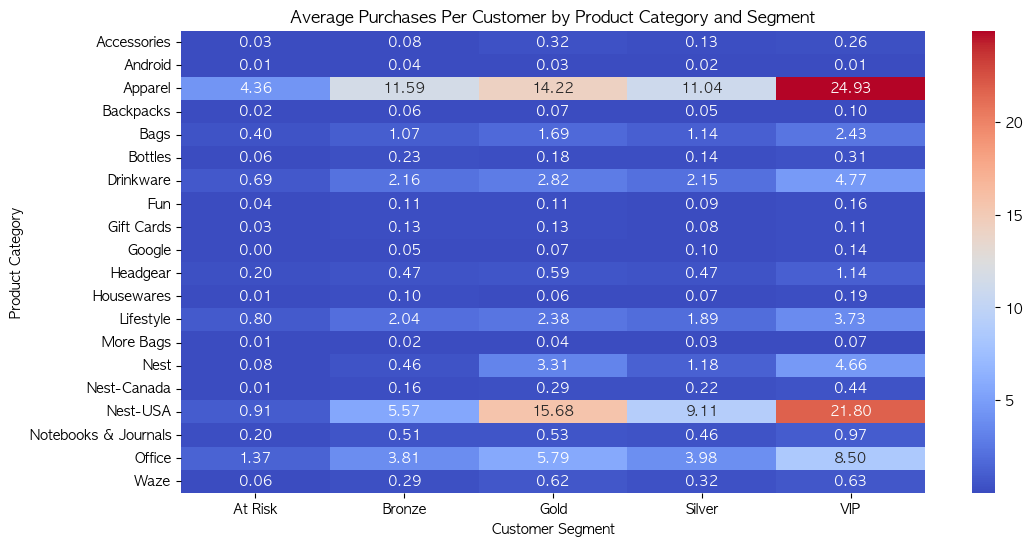

In [265]:
# 세그먼트별 총 거래 횟수 계산
category_counts = merged_df.groupby(['customer_segment', '제품카테고리'])['거래ID'].count().reset_index()

# 각 세그먼트별 고객 수 계산
customer_counts = merged_df.groupby('customer_segment')['고객ID'].nunique().reset_index()
customer_counts.columns = ['customer_segment', 'customer_count']

# 고객 수를 기준으로 인당 평균 구매량 계산
category_counts = category_counts.merge(customer_counts, on='customer_segment', how='left')
category_counts['avg_purchases_per_customer'] = category_counts['거래ID'] / category_counts['customer_count']

# 피벗 테이블 변환
category_counts_pivot = category_counts.pivot(index='제품카테고리', columns='customer_segment', values='avg_purchases_per_customer')

# 히트맵 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(category_counts_pivot, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Average Purchases Per Customer by Product Category and Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Product Category")
plt.show()

세그먼트별 쿠폰 사용량

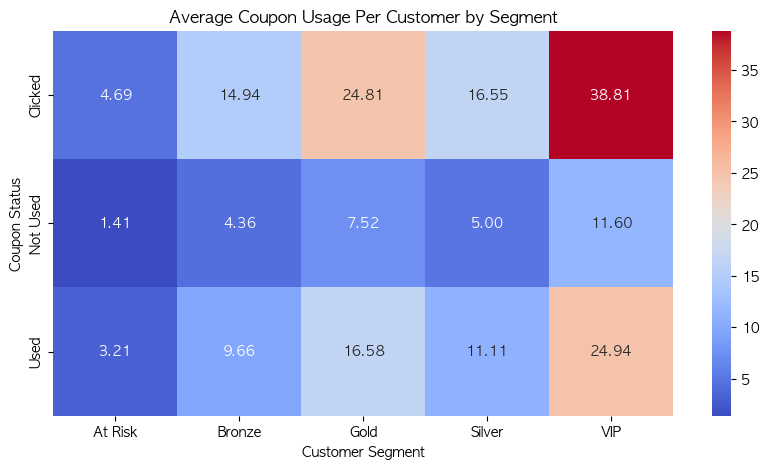

In [268]:
# 고객 세그먼트별 쿠폰 사용 횟수 계산
coupon_usage = merged_df.groupby(['customer_segment', '쿠폰상태'])['거래ID'].count().reset_index()

# 각 세그먼트별 고객 수 계산
customer_counts = merged_df.groupby('customer_segment')['고객ID'].nunique().reset_index()
customer_counts.columns = ['customer_segment', 'customer_count']

# 고객 수 기준으로 인당 평균 쿠폰 사용 횟수 계산
coupon_usage = coupon_usage.merge(customer_counts, on='customer_segment', how='left')
coupon_usage['avg_coupon_usage_per_customer'] = coupon_usage['거래ID'] / coupon_usage['customer_count']

# 피벗 테이블 변환
coupon_usage_pivot = coupon_usage.pivot(index='쿠폰상태', columns='customer_segment', values='avg_coupon_usage_per_customer')

# 히트맵 시각화
plt.figure(figsize=(10, 5))
sns.heatmap(coupon_usage_pivot, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Average Coupon Usage Per Customer by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Coupon Status")
plt.show()

세그먼트별 구매 시즌성 확인

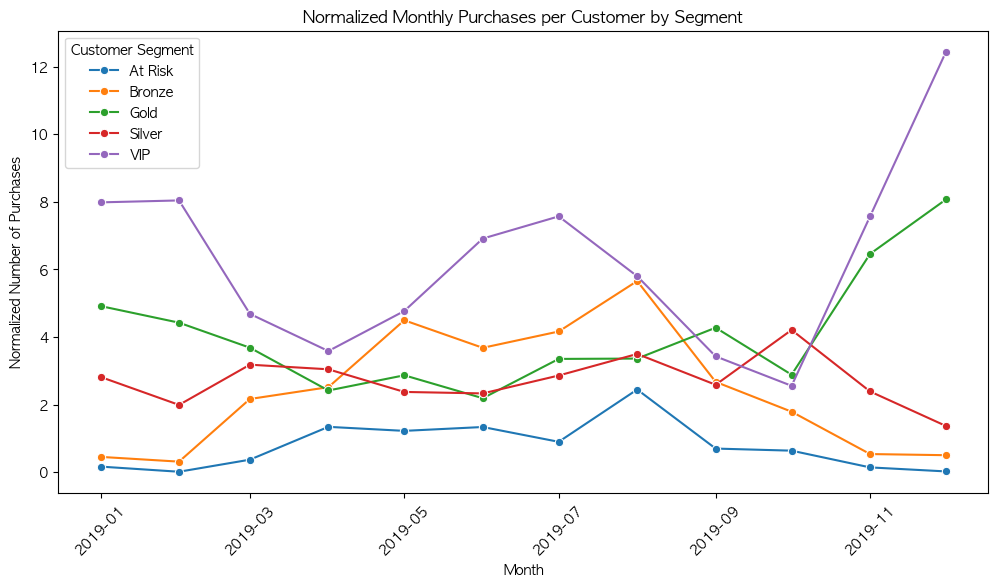

In [271]:
# 고객 세그먼트별 월별 거래 횟수 계산
monthly_purchases = merged_df.groupby(['거래월', 'customer_segment'])['거래ID'].count().reset_index()

# 각 세그먼트별 고객 수 계산
customer_counts = merged_df.groupby('customer_segment')['고객ID'].nunique().reset_index()
customer_counts.columns = ['customer_segment', 'customer_count']

# 고객 수를 기준으로 인당 평균 월별 구매량 계산
monthly_purchases = monthly_purchases.merge(customer_counts, on='customer_segment', how='left')
monthly_purchases['normalized_purchases'] = monthly_purchases['거래ID'] / monthly_purchases['customer_count']

# 거래월을 datetime 형식으로 변환
monthly_purchases['거래월'] = monthly_purchases['거래월'].astype(str)
monthly_purchases['거래월'] = pd.to_datetime(monthly_purchases['거래월'])

# 월별 정규화된 구매 횟수 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_purchases, x='거래월', y='normalized_purchases', hue='customer_segment', marker='o', palette='tab10')
plt.title("Normalized Monthly Purchases per Customer by Segment")
plt.xlabel("Month")
plt.ylabel("Normalized Number of Purchases")
plt.xticks(rotation=45)
plt.legend(title="Customer Segment")
plt.show()


세그먼트별 요일 구매량 차이 확인

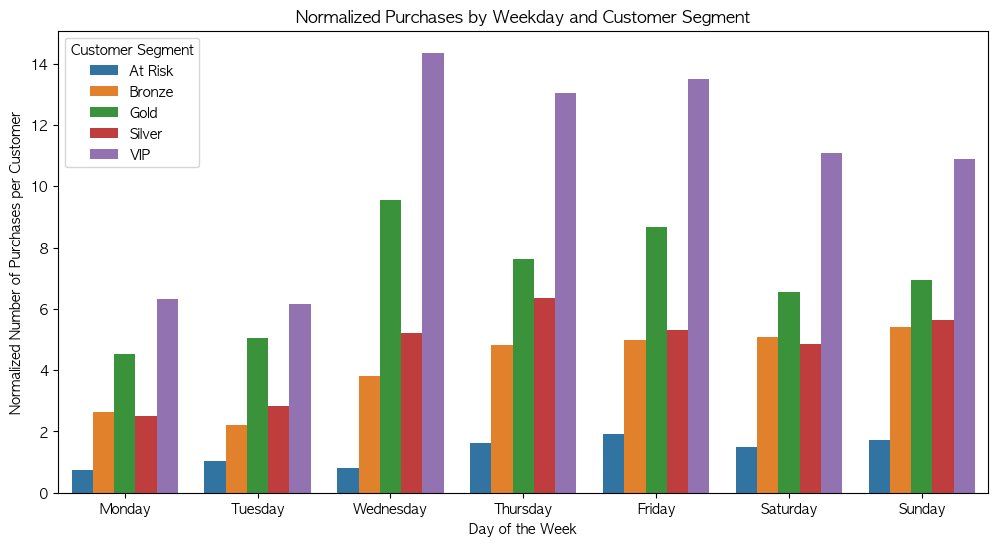

In [273]:
merged_df['거래요일'] = merged_df['거래날짜'].dt.day_name()

# 각 세그먼트별 고객 수 계산
customer_counts = merged_df.groupby('customer_segment')['고객ID'].nunique().reset_index()
customer_counts.columns = ['customer_segment', 'customer_count']

# 요일별 총 거래 횟수 계산
weekday_purchases = merged_df.groupby(['거래요일', 'customer_segment'])['거래ID'].count().reset_index()

# 고객 수 기준으로 인당 평균 요일별 구매량 계산
weekday_purchases = weekday_purchases.merge(customer_counts, on='customer_segment', how='left')
weekday_purchases['normalized_purchases'] = weekday_purchases['거래ID'] / weekday_purchases['customer_count']

# 요일 순서 정리 (월~일)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_purchases['거래요일'] = pd.Categorical(weekday_purchases['거래요일'], categories=weekday_order, ordered=True)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=weekday_purchases, x='거래요일', y='normalized_purchases', hue='customer_segment', palette='tab10')
plt.title("Normalized Purchases by Weekday and Customer Segment")
plt.xlabel("Day of the Week")
plt.ylabel("Normalized Number of Purchases per Customer")
plt.legend(title="Customer Segment")
plt.show()

세그먼트별 장바구니 분석을 통한 연관 상품 차이 확인

In [290]:
# 클러스터 정보 추가 (고객ID를 기준으로 customer_segment 병합)
merged_df = df_on.merge(clv_df[['고객ID', 'customer_segment']], on='고객ID', how='left')

# 고객 ID와 거래 날짜를 기준으로 새로운 거래 ID 생성
merged_df['거래ID'] = merged_df.groupby(['고객ID', '거래날짜']).ngroup() + 1

# 클러스터 + 새로운 거래ID 기준으로 장바구니 데이터 생성 (제품 카테고리 기준)
basket_cluster = merged_df.groupby(['customer_segment', '거래ID'])['제품카테고리'].apply(list).reset_index()

# 결과 확인
basket_cluster.head()

,customer_segment,거래ID,제품카테고리
0,At Risk,1,"[Apparel, Office]"
1,At Risk,9,"[Headgear, Nest-USA, Apparel, Apparel, Apparel..."
2,At Risk,21,"[Nest-USA, Apparel, Apparel, Nest-USA, Nest-US..."
3,At Risk,42,"[Office, Apparel, Apparel, Lifestyle, Apparel,..."
4,At Risk,54,"[Lifestyle, Office, Office]"


In [291]:
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

# 클러스터별 연관 규칙 저장용 딕셔너리
cluster_rules = {}

for cluster in basket_cluster['customer_segment'].unique():
    print(f"\n클러스터 {cluster}의 장바구니 분석 중 (제품 카테고리 기준)...")

    # 특정 클러스터의 장바구니 데이터만 필터링
    cluster_basket_list = basket_cluster[basket_cluster['customer_segment'] == cluster]['제품카테고리'].tolist()

    # 트랜잭션 인코딩 (One-Hot Encoding)
    te = TransactionEncoder()
    te_ary = te.fit(cluster_basket_list).transform(cluster_basket_list)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Apriori 알고리즘 적용 (최소 지지도 0.01 설정)
    frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

    # 연관 규칙 생성 (지지도, 신뢰도, 향상도)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    # 결과 저장
    cluster_rules[cluster] = rules.sort_values("lift", ascending=False)

    # 상위 5개 규칙 출력
    print(cluster_rules[cluster].head(5))


🔍 클러스터 At Risk의 장바구니 분석 중 (제품 카테고리 기준)...
                                        antecedents  \
7571          (Apparel, Lifestyle, Drinkware, Bags)   
7608                (Bottles, Notebooks & Journals)   
5441                (Bottles, Notebooks & Journals)   
5420          (Apparel, Lifestyle, Drinkware, Bags)   
7537  (Apparel, Office, Bags, Drinkware, Lifestyle)   

                                        consequents  antecedent support  \
7571        (Office, Bottles, Notebooks & Journals)                0.08   
7608  (Apparel, Office, Bags, Drinkware, Lifestyle)                0.01   
5441          (Apparel, Lifestyle, Drinkware, Bags)                0.01   
5420                (Bottles, Notebooks & Journals)                0.08   
7537                (Bottles, Notebooks & Journals)                0.08   

      consequent support  support  confidence  lift  representativity  \
7571                0.01     0.01        0.15 12.15              1.00   
7608                0.08     

In [301]:
# 각 세그먼트별 연관 상품 비교 데이터 생성 (상위 10개만 저장)
segment_comparisons = []

for cluster in cluster_rules.keys():
    df_br = cluster_rules[cluster][['antecedents', 'consequents', 'lift']].copy()
    df_br['Segment'] = cluster
    df_br['FROM'] = df_br['antecedents'].apply(lambda x: list(x)[0])
    df_br['TO'] = df_br['consequents'].apply(lambda x: list(x)[0])
    
    # Lift 값 기준 상위 10개만 선택
    df_br_top10 = df_br.nlargest(10, 'lift')  
    segment_comparisons.append(df_br_top10[['Segment', 'FROM', 'TO', 'lift']])

# 하나의 데이터프레임으로 합치기
comparison_df_top10 = pd.concat(segment_comparisons)

comparison_df_top10


,Segment,FROM,TO,lift
7571,At Risk,Apparel,Office,12.15
7608,At Risk,Bottles,Apparel,12.15
5441,At Risk,Bottles,Apparel,12.15
5420,At Risk,Apparel,Bottles,12.15
7537,At Risk,Apparel,Bottles,12.15
7574,At Risk,Office,Apparel,12.15
7177,At Risk,Bottles,Lifestyle,11.57
7573,At Risk,Apparel,Lifestyle,11.57
7156,At Risk,Lifestyle,Bottles,11.57
7572,At Risk,Lifestyle,Apparel,11.57



At Risk Segment - Product Association Network


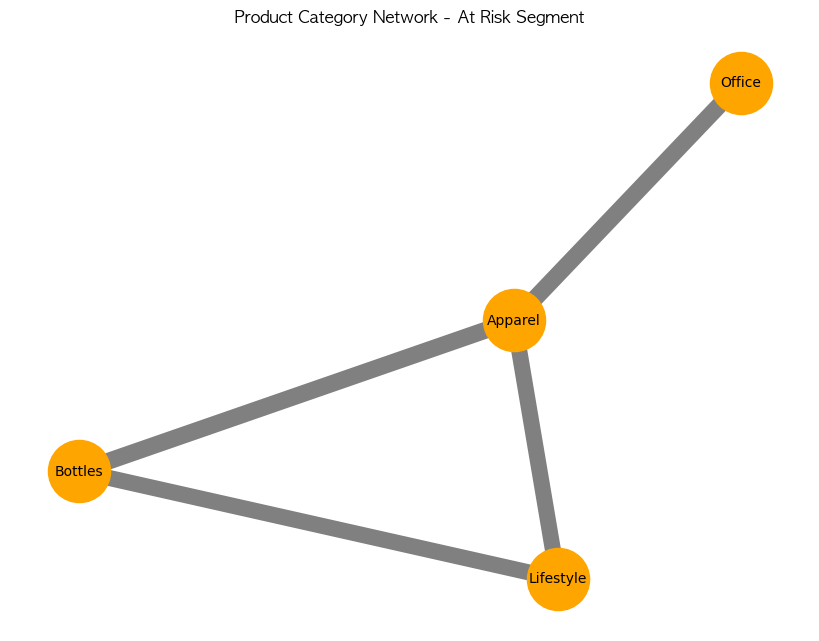


Bronze Segment - Product Association Network


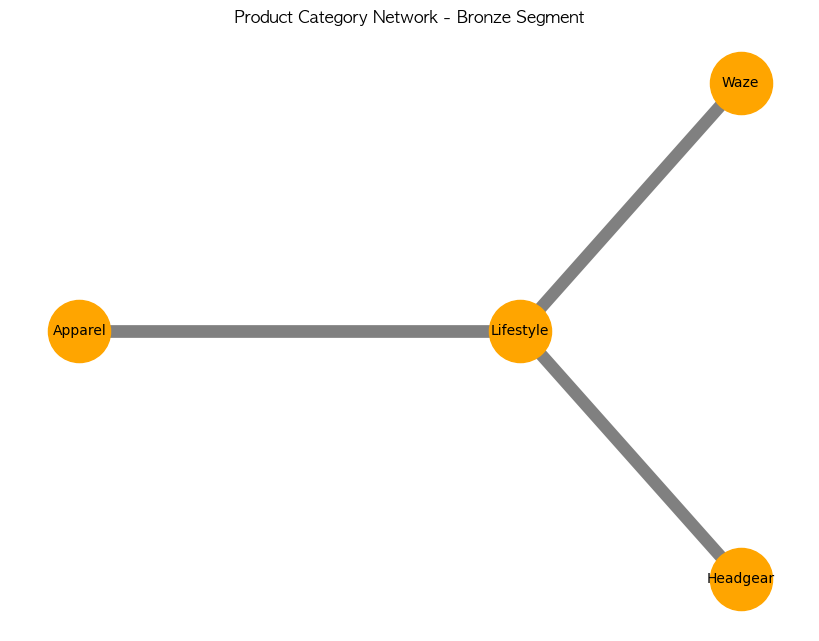


Gold Segment - Product Association Network


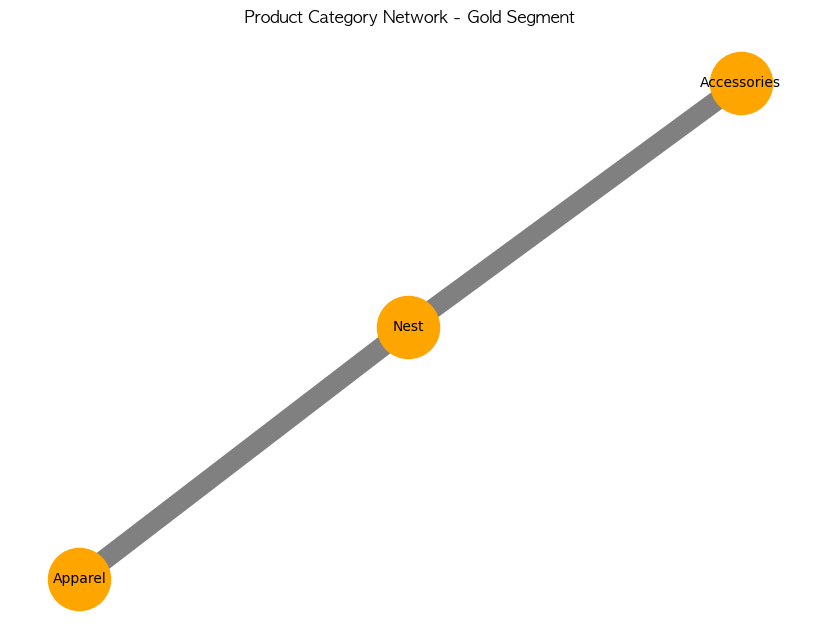


Silver Segment - Product Association Network


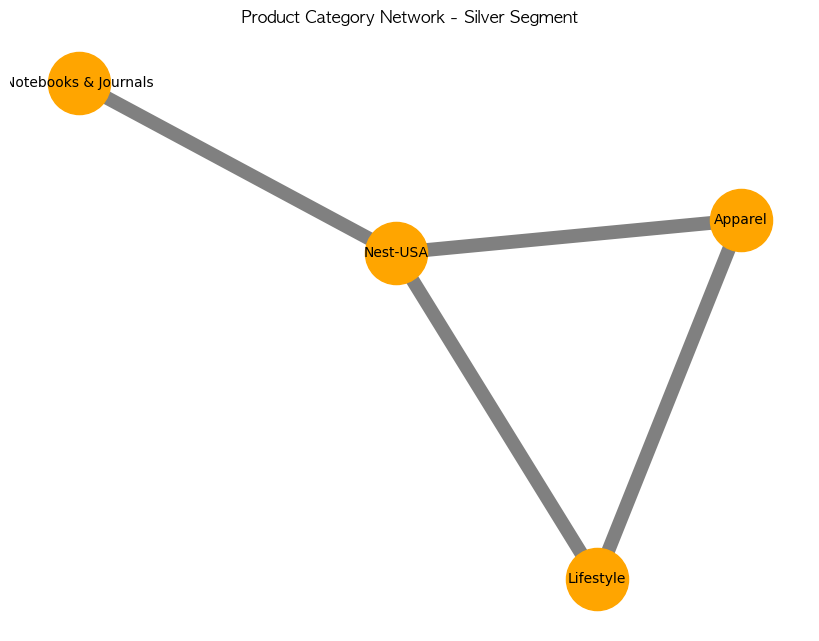


VIP Segment - Product Association Network


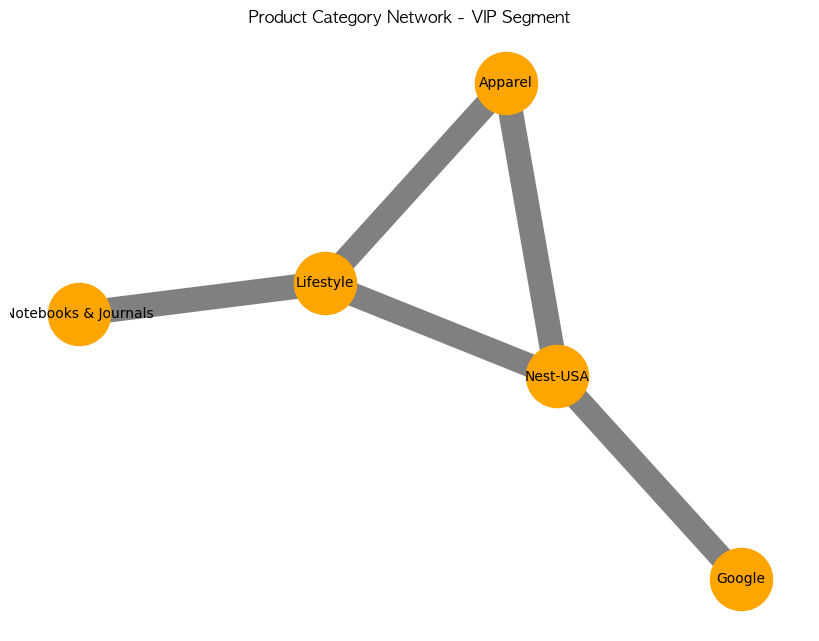

In [424]:
import networkx as nx
import matplotlib.pyplot as plt

# 세그먼트별 네트워크 그래프 생성 및 시각화
for cluster in comparison_df_top10['Segment'].unique():
    print(f"\n{cluster} Segment - Product Asㄴsociation Network")

    # 특정 세그먼트의 데이터 필터링
    df_br = comparison_df_top10[comparison_df_top10['Segment'] == cluster]
    
    # 네트워크 그래프 생성
    G = nx.from_pandas_edgelist(df_br, source='FROM', target='TO', edge_attr=True)

    # 네트워크 시각화
    plt.figure(figsize=(8, 6))
    pos = nx.kamada_kawai_layout(G)  # 노드 배치 알고리즘 적용
    nx.draw(G, pos, with_labels=True, node_color='orange', node_size=2000, edge_color='gray', font_size=10, font_color='black')

    # 엣지 두께를 Lift 값 기반으로 설정
    edges = G.edges(data=True)
    weights = [data['lift'] for _, _, data in edges]  # lift 값만 리스트로 추출
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=weights, edge_color='gray')

    plt.title(f"Product Category Network - {cluster} Segment")
    plt.show()


# 3. 개인 맞춤형 What? & When? 제공하기
- 언제 살건데?
- 뭘 살건데?

-> 언제 무엇을 살지 조합하여 마케팅 활동

## 3.1 고객들의 평균 구매 주기 예측하기

In [336]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 고객별 평균 구매 간격 계산 (Target 값)
purchase_intervals = df_on.sort_values(['고객ID', '거래날짜']).groupby('고객ID')['거래날짜'].diff().dt.days
customer_avg_interval = purchase_intervals.groupby(df_on['고객ID']).mean().reset_index()
customer_avg_interval.columns = ['고객ID', '평균구매간격']

# 쿠폰 사용 비율
coupon_usage = df_on.groupby('고객ID')['쿠폰상태'].apply(lambda x: (x == 'Used').sum() / len(x)).reset_index()
coupon_usage.columns = ['고객ID', '쿠폰사용비율']

# 월별 평균 구매 횟수
df_on['거래월'] = df_on['거래날짜'].dt.to_period('M')
monthly_purchases = df_on.groupby(['고객ID', '거래월']).size().groupby('고객ID').mean().reset_index()
monthly_purchases.columns = ['고객ID', '월평균구매횟수']

# 고객 데이터와 병합 (가입기간, 성별 등 추가)
clv_extended_df = clv_df.merge(customer_avg_interval, on='고객ID', how='left') \
                         .merge(coupon_usage, on='고객ID', how='left') \
                         .merge(monthly_purchases, on='고객ID', how='left') \
                         .merge(df_cus[['고객ID', '성별', '고객지역', '가입기간']], on='고객ID', how='left')
                         
print(clv_extended_df.columns)

Index(['고객ID', 'recency', 'frequency', 'monetary', 'T',
       'predicted_purchases_3_months', 'CLV_3_months', 'R_score', 'F_score',
       'M_score', 'T_score', 'CLV_score', 'final_score', 'customer_segment',
       '평균구매간격', '쿠폰사용비율', '월평균구매횟수', '성별', '고객지역', '가입기간'],
      dtype='object')


In [338]:
# 평균 구매 간격이 NaN인 경우 → 한번만 구매한 경우이므로 Recency 값으로 대체하여 예측하도록 함.
clv_extended_df['평균구매간격'].fillna(clv_extended_df['recency'], inplace=True)

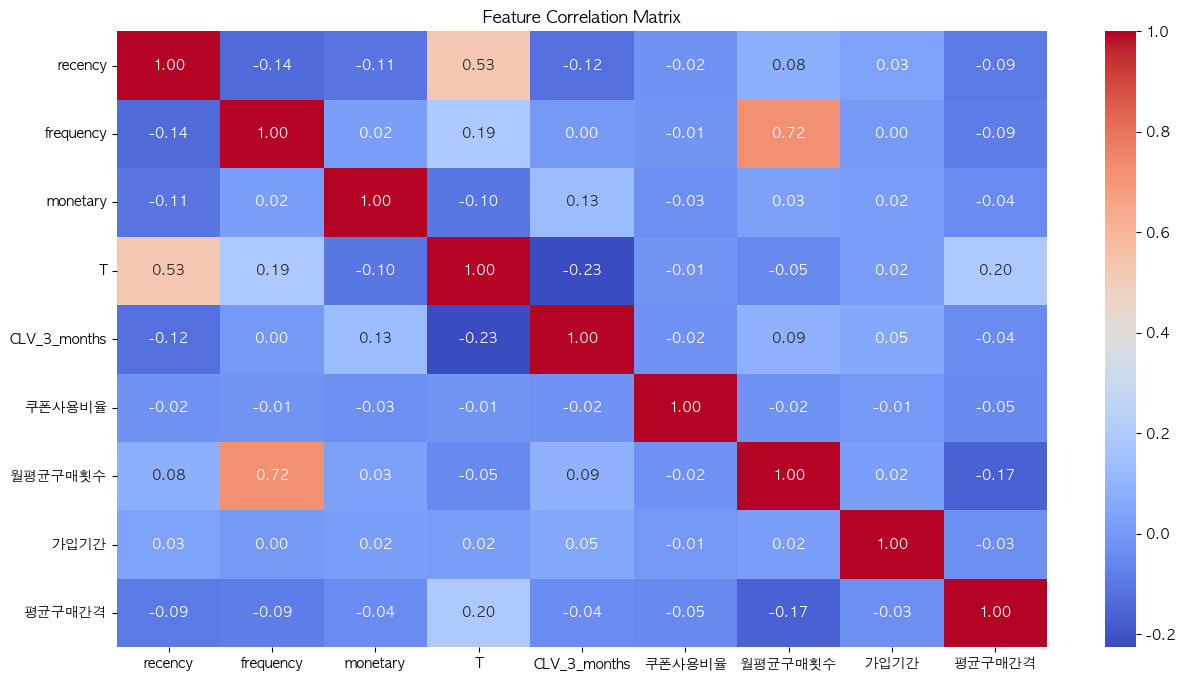

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['recency', 'frequency', 'monetary', 'T', 'CLV_3_months', 
'쿠폰사용비율', '월평균구매횟수', '가입기간', '평균구매간격']

# 상관관계 분석 (평균 구매 간격과 비교)
correlation_matrix = clv_extended_df[features].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 예측 변수(X) 및 타겟 변수(y) 설정
features = ['recency', 'frequency', 'monetary', 'T', 'CLV_3_months', 
'쿠폰사용비율', '월평균구매횟수', '성별', '고객지역','가입기간']

X = clv_extended_df[features]
y = clv_extended_df['평균구매간격']

# 범주형 & 연속형 변수 구분 각각 유니크한 범주 값이 2,5개 이므로 원핫인코딩으로 결정
categorical_features = ['성별', '고객지역']
numerical_features = [col for col in features if col not in categorical_features]

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # 연속형 변수: 정규화
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # 범주형 변수: 원핫 인코딩
    ]
)

# 데이터 변환
X_processed = preprocessor.fit_transform(X)

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [414]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, n_estimators=1000, max_depth=3, random_state=42)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 2.12, MAE: 0.72


## 3.2 고객들의 연관구매상품 추천하기

In [416]:
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder

# 거래 ID를 새롭게 부여 (거래 날짜 기준 그룹화)
df_on_sorted = df_on.sort_values(['고객ID', '거래날짜'])
df_on_sorted['거래ID'] = df_on_sorted.groupby(['고객ID', '거래날짜']).ngroup() + 1

# 고객별 거래 내역을 리스트화 (거래 ID 기준 그룹화)
transactions = df_on_sorted.groupby('거래ID')['제품ID'].apply(list)

# 트랜잭션 인코딩 (One-Hot Encoding)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori 알고리즘 적용 (최소 지지도 0.01 설정)
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# 연관 규칙 생성 (지지도, 신뢰도, 향상도)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 제품 ID 기반 추천을 위한 딕셔너리 생성
recommendation_dict = {}

for _, row in rules.iterrows():
    antecedent = list(row['antecedents'])[0]  # 연관 상품 A
    consequent = list(row['consequents'])[0]  # 연관 상품 B
    if antecedent not in recommendation_dict:
        recommendation_dict[antecedent] = []
    recommendation_dict[antecedent].append((consequent, row['lift']))  # 향상도 기준 저장

# 고객별 연관 상품 추천 함수
def recommend_products(customer_id, df_on_sorted, recommendation_dict, top_n=5):
    """ 특정 고객의 최근 구매 제품을 기준으로 연관 상품 추천 """
    customer_products = df_on_sorted[df_on_sorted['고객ID'] == customer_id]['제품ID'].unique()
    recommendations = []

    for product in customer_products:
        if product in recommendation_dict:
            recommendations.extend(recommendation_dict[product])

    # 향상도 기준 정렬 후 상위 3~5개 추천
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return [rec[0] for rec in recommendations[:top_n]]

# 고객별 연관 상품 추천 적용
df_on_sorted['추천제품'] = df_on_sorted['고객ID'].apply(lambda x: recommend_products(x, df_on_sorted, recommendation_dict))

,고객ID,추천제품
38120,USER_0000,"[Product_0992, Product_0990, Product_0969, Pro..."
38125,USER_0000,"[Product_0992, Product_0990, Product_0969, Pro..."
10667,USER_0001,"[Product_0880, Product_0916, Product_0916, Pro..."
10668,USER_0001,"[Product_0880, Product_0916, Product_0916, Pro..."
10669,USER_0001,"[Product_0880, Product_0916, Product_0916, Pro..."
...,...,...
41616,USER_1467,"[Product_0880, Product_0916, Product_0880, Pro..."
41617,USER_1467,"[Product_0880, Product_0916, Product_0880, Pro..."
41618,USER_1467,"[Product_0880, Product_0916, Product_0880, Pro..."
41619,USER_1467,"[Product_0880, Product_0916, Product_0880, Pro..."


In [422]:
# 리스트 타입 컬럼을 문자열로 변환 후 중복 제거
df_on_sorted['추천제품_str'] = df_on_sorted['추천제품'].astype(str)  # 리스트 → 문자열 변환
df_on_sorted_unique = df_on_sorted.drop_duplicates(subset=['고객ID', '추천제품_str'])  # 중복 제거

df_on_sorted_unique[['고객ID', '추천제품']]

,고객ID,추천제품
38120,USER_0000,"[Product_0992, Product_0990, Product_0969, Pro..."
10667,USER_0001,"[Product_0880, Product_0916, Product_0916, Pro..."
23561,USER_0002,"[Product_0880, Product_0916, Product_0880, Pro..."
50740,USER_0003,"[Product_0880, Product_0916, Product_0916, Pro..."
38084,USER_0004,"[Product_0880, Product_0880, Product_0880, Pro..."
...,...,...
12216,USER_1463,"[Product_0880, Product_0985, Product_0908, Pro..."
23496,USER_1464,"[Product_0916, Product_0916, Product_0916, Pro..."
12242,USER_1465,"[Product_0994, Product_0880, Product_0976, Pro..."
43154,USER_1466,"[Product_0880, Product_0880, Product_0916, Pro..."
